### Initial Setup

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ca25428b-9e2f-248b-2461-a57d07873da0)


In [2]:
!rm -r /content/ComputerVision101

In [3]:
!git clone "https://github.com/akshatjaipuria/ComputerVision101.git"

Cloning into 'ComputerVision101'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 242 (delta 79), reused 201 (delta 48), pack-reused 0
Receiving objects: 100% (242/242), 3.82 MiB | 18.47 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [4]:
%cd '/content/ComputerVision101'

/content/ComputerVision101


In [5]:
!pip install torch_lr_finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Dataloaders

In [6]:
import torch
import torchvision
import torch.nn as nn

In [7]:
device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")
print (f"Device: {device}")

Device: cuda:0


In [8]:
# Mean and STD for CIFAR-10
mean = (0.4914, 0.48216, 0.44653)
std = (0.24703, 0.24349, 0.26159)

# Class labels for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
import albumentations as alb
from albumentations.pytorch import ToTensorV2
import numpy as np

class TrainTransforms:
    def __init__(self, pMean, pStd):
        self.fill_value = [i * 255 for i in pMean]
        self.train_transform = alb.Compose([
            alb.Resize(32, 32, 3),
            alb.PadIfNeeded(min_height=40, min_width=40,),
            alb.RandomCrop(32, 32,),
            alb.HorizontalFlip(p=.5),
            alb.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=self.fill_value, mask_fill_value=None),
            alb.Normalize(mean=pMean, std=pStd),
            ToTensorV2(),
        ])

    def __call__(self, img):
        img = np.array(img)
        img = self.train_transform(image=img)['image']
        return img


class TestTransforms:
    def __init__(self, pMean, pStd):
        self.test_transform = alb.Compose([
            alb.Resize(32, 32, 3),
            alb.Normalize(mean=pMean, std=pStd),
            ToTensorV2(),
        ])

    def __call__(self, img):
        img = np.array(img)
        img = self.test_transform(image=img)['image']
        return img

In [10]:
from pytorch_cv.utils.data_loader import GetDataLoaders

train_loader, test_loader = GetDataLoaders(torchvision.datasets.CIFAR10, TrainTransforms(mean, std), TestTransforms(mean, std))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CUDA Available? True


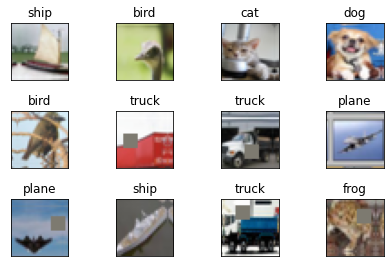

In [11]:
from pytorch_cv.utils.visualizer import DisplayData

DisplayData (train_loader, classes, [mean, std])

### Model and training

In [12]:
from pytorch_cv.models.custom_resnet import CustomResNet
net = CustomResNet()

In [13]:
from pytorch_cv.utils.utils import PrintSummary
net.to(device)
PrintSummary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.61E-02


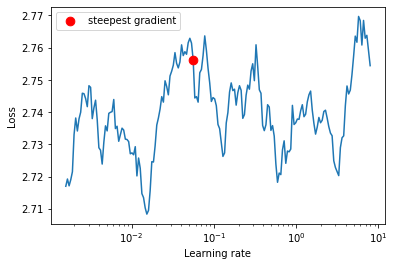

Min loss (2.708336845357326) is at LR: 0.015343684089300124


In [14]:
from pytorch_cv.utils.utils import FindLR

net_ = CustomResNet()
criterion = nn.CrossEntropyLoss
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
max_lr = FindLR(net_, optimizer, criterion(), train_loader, device)

In [ ]:
net = CustomResNet()
net.to(device)

In [16]:
optimizer = torch.optim.SGD(net.parameters(), lr=max_lr, momentum=0.9)
epochs = 24
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr,
                                                            steps_per_epoch=len(train_loader), epochs=epochs,
                                                            pct_start=(5/epochs), anneal_strategy='linear', 
                                                            div_factor=10, three_phase=False,)

In [17]:
from pytorch_cv.utils.trainer import TrainModel

data_dict = TrainModel(net, train_loader, test_loader, nn.CrossEntropyLoss, optimizer, False, epochs, device, scheduler)

-------------- Epoch 1 --------------


Train: LR=0.004291 Loss=1.0224 Batch_id=390 Accuracy=48.96: 100%|██████████| 391/391 [00:26<00:00, 14.72it/s]


Test: Average loss: 1.0156, Accuracy: 6504/10000 (65.04%)

-------------- Epoch 2 --------------


Train: LR=0.007054 Loss=0.6972 Batch_id=390 Accuracy=66.68: 100%|██████████| 391/391 [00:25<00:00, 15.23it/s]


Test: Average loss: 1.0354, Accuracy: 6951/10000 (69.51%)

-------------- Epoch 3 --------------


Train: LR=0.009817 Loss=0.8651 Batch_id=390 Accuracy=72.64: 100%|██████████| 391/391 [00:25<00:00, 15.51it/s]


Test: Average loss: 0.8136, Accuracy: 7528/10000 (75.28%)

-------------- Epoch 4 --------------


Train: LR=0.012580 Loss=0.5574 Batch_id=390 Accuracy=76.94: 100%|██████████| 391/391 [00:25<00:00, 15.24it/s]


Test: Average loss: 0.6914, Accuracy: 7942/10000 (79.42%)

-------------- Epoch 5 --------------


Train: LR=0.015344 Loss=0.7070 Batch_id=390 Accuracy=79.45: 100%|██████████| 391/391 [00:25<00:00, 15.37it/s]


Test: Average loss: 0.5022, Accuracy: 8358/10000 (83.58%)

-------------- Epoch 6 --------------


Train: LR=0.014536 Loss=0.3698 Batch_id=390 Accuracy=82.24: 100%|██████████| 391/391 [00:25<00:00, 15.36it/s]


Test: Average loss: 0.5356, Accuracy: 8330/10000 (83.30%)

-------------- Epoch 7 --------------


Train: LR=0.013729 Loss=0.2192 Batch_id=390 Accuracy=84.22: 100%|██████████| 391/391 [00:25<00:00, 15.43it/s]


Test: Average loss: 0.4668, Accuracy: 8500/10000 (85.00%)

-------------- Epoch 8 --------------


Train: LR=0.012921 Loss=0.4068 Batch_id=390 Accuracy=86.24: 100%|██████████| 391/391 [00:26<00:00, 15.00it/s]


Test: Average loss: 0.4317, Accuracy: 8619/10000 (86.19%)

-------------- Epoch 9 --------------


Train: LR=0.012113 Loss=0.3918 Batch_id=390 Accuracy=87.18: 100%|██████████| 391/391 [00:25<00:00, 15.34it/s]


Test: Average loss: 0.3810, Accuracy: 8775/10000 (87.75%)

-------------- Epoch 10 --------------


Train: LR=0.011306 Loss=0.3838 Batch_id=390 Accuracy=88.51: 100%|██████████| 391/391 [00:25<00:00, 15.46it/s]


Test: Average loss: 0.6016, Accuracy: 8367/10000 (83.67%)

-------------- Epoch 11 --------------


Train: LR=0.010498 Loss=0.3291 Batch_id=390 Accuracy=89.33: 100%|██████████| 391/391 [00:25<00:00, 15.46it/s]


Test: Average loss: 0.3624, Accuracy: 8823/10000 (88.23%)

-------------- Epoch 12 --------------


Train: LR=0.009691 Loss=0.1887 Batch_id=390 Accuracy=90.33: 100%|██████████| 391/391 [00:25<00:00, 15.37it/s]


Test: Average loss: 0.4002, Accuracy: 8789/10000 (87.89%)

-------------- Epoch 13 --------------


Train: LR=0.008883 Loss=0.3165 Batch_id=390 Accuracy=91.54: 100%|██████████| 391/391 [00:25<00:00, 15.42it/s]


Test: Average loss: 0.3717, Accuracy: 8830/10000 (88.30%)

-------------- Epoch 14 --------------


Train: LR=0.008076 Loss=0.3273 Batch_id=390 Accuracy=92.12: 100%|██████████| 391/391 [00:25<00:00, 15.42it/s]


Test: Average loss: 0.3347, Accuracy: 8931/10000 (89.31%)

-------------- Epoch 15 --------------


Train: LR=0.007268 Loss=0.2719 Batch_id=390 Accuracy=92.47: 100%|██████████| 391/391 [00:25<00:00, 15.39it/s]


Test: Average loss: 0.3539, Accuracy: 8945/10000 (89.45%)

-------------- Epoch 16 --------------


Train: LR=0.006461 Loss=0.0999 Batch_id=390 Accuracy=93.64: 100%|██████████| 391/391 [00:26<00:00, 14.98it/s]


Test: Average loss: 0.3274, Accuracy: 8998/10000 (89.98%)

-------------- Epoch 17 --------------


Train: LR=0.005653 Loss=0.0658 Batch_id=390 Accuracy=94.15: 100%|██████████| 391/391 [00:25<00:00, 15.43it/s]


Test: Average loss: 0.3411, Accuracy: 8960/10000 (89.60%)

-------------- Epoch 18 --------------


Train: LR=0.004845 Loss=0.1891 Batch_id=390 Accuracy=94.55: 100%|██████████| 391/391 [00:25<00:00, 15.16it/s]


Test: Average loss: 0.3029, Accuracy: 9118/10000 (91.18%)

-------------- Epoch 19 --------------


Train: LR=0.004038 Loss=0.2393 Batch_id=390 Accuracy=95.34: 100%|██████████| 391/391 [00:25<00:00, 15.27it/s]


Test: Average loss: 0.3083, Accuracy: 9085/10000 (90.85%)

-------------- Epoch 20 --------------


Train: LR=0.003230 Loss=0.1418 Batch_id=390 Accuracy=95.89: 100%|██████████| 391/391 [00:27<00:00, 14.43it/s]


Test: Average loss: 0.3140, Accuracy: 9110/10000 (91.10%)

-------------- Epoch 21 --------------


Train: LR=0.002423 Loss=0.1255 Batch_id=390 Accuracy=96.34: 100%|██████████| 391/391 [00:25<00:00, 15.30it/s]


Test: Average loss: 0.3037, Accuracy: 9109/10000 (91.09%)

-------------- Epoch 22 --------------


Train: LR=0.001615 Loss=0.1368 Batch_id=390 Accuracy=97.06: 100%|██████████| 391/391 [00:25<00:00, 15.42it/s]


Test: Average loss: 0.2867, Accuracy: 9187/10000 (91.87%)

-------------- Epoch 23 --------------


Train: LR=0.000808 Loss=0.0994 Batch_id=390 Accuracy=97.45: 100%|██████████| 391/391 [00:26<00:00, 14.83it/s]


Test: Average loss: 0.2775, Accuracy: 9202/10000 (92.02%)

-------------- Epoch 24 --------------


Train: LR=0.000000 Loss=0.0516 Batch_id=390 Accuracy=97.92: 100%|██████████| 391/391 [00:25<00:00, 15.43it/s]


Test: Average loss: 0.2746, Accuracy: 9224/10000 (92.24%)



### Misclassified images (from Test set)

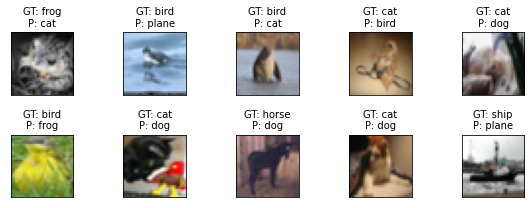

In [18]:
from pytorch_cv.utils.visualizer import DisplayIncorrectPredictions

DisplayIncorrectPredictions (data_dict['incorrect_pred'], classes, [mean, std])

### Loss/Accuracy graphs

In [19]:
from pytorch_cv.utils.visualizer import PlotTrainVsTest

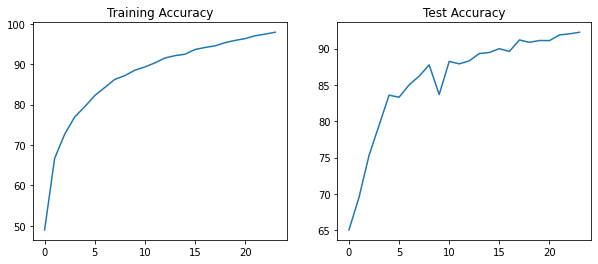

In [20]:
# Accuracy curves
PlotTrainVsTest (("Training Accuracy", data_dict['train_acc']), ("Test Accuracy", data_dict['test_acc']))

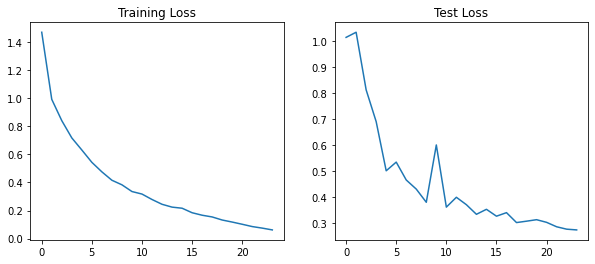

In [21]:
# Loss curves
PlotTrainVsTest (("Training Loss", data_dict['train_loss']), ("Test Loss", data_dict['test_loss']))

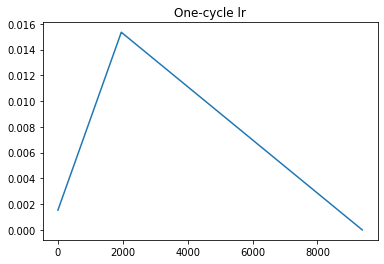

In [22]:
import matplotlib.pyplot as plt
plt.plot(data_dict['lr_history'])
plt.title('One-cycle lr')
plt.show()